In [9]:
!pip uninstall -y transformers -q
!pip install -q transformers>=4.10

In [7]:
!pip install -q --upgrade transformers datasets peft accelerate \
  sentence-transformers evaluate textdistance sacrebleu matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import os, random, numpy as np, torch, textdistance, evaluate, pandas as pd, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
from peft import LoraConfig, get_peft_model
from sentence_transformers import SentenceTransformer, util

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}, GPUs disponibles: {torch.cuda.device_count()}")

Usando dispositivo: cuda, GPUs disponibles: 1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/102747 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12844 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12843 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['es', 'qu'],
        num_rows: 102747
    })
    validation: Dataset({
        features: ['es', 'qu'],
        num_rows: 12844
    })
    test: Dataset({
        features: ['es', 'qu'],
        num_rows: 12843
    })
})
Ejemplo: {'es': 'Y por último dice que el pueblo de Dios “escapará, todo el que se halle escrito en el libro ”.', 'qu': 'Ichaqa chaywanpas chay tiempopim llaqtamasikikuna librasqa kanqaku. Libropi qillqasqa sutiyuqkunam lliw librakunqaku ’, nispa (Dan.'}


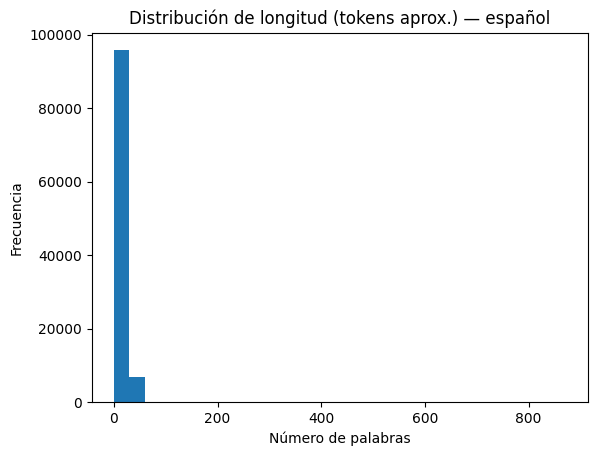

In [9]:
dataset = load_dataset("somosnlp-hackathon-2022/spanish-to-quechua")
print(dataset)
print("Ejemplo:", dataset["train"][0])

# histograma de longitudes en español
lengths = [len(x.split()) for x in dataset["train"]["es"]]
plt.hist(lengths, bins=30)
plt.title("Distribución de longitud (tokens aprox.) — español")
plt.xlabel("Número de palabras"); plt.ylabel("Frecuencia"); plt.show()

In [10]:
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          src_lang="spa_Latn",
                                          tgt_lang="que_Latn")
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [11]:
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"], # cross-attn keys
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(base_model, lora_cfg).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params/total_params:.2%}")



Parámetros entrenables: 0.19%


In [12]:

max_length = 64

def preprocess_function(examples):
    #"es" y "qu"
    inputs  = examples["es"]
    targets = examples["qu"]
    model_inputs = tokenizer(
        inputs, max_length=max_length, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        targets, max_length=max_length, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# mapea sobre cada split para crear los dataset tokenizados
train_tok = dataset["train"].map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)
val_tok = dataset["validation"].map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["validation"].column_names
)
test_tok = dataset["test"].map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["test"].column_names
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/102747 [00:00<?, ? examples/s]

Map:   0%|          | 0/12844 [00:00<?, ? examples/s]

Map:   0%|          | 0/12843 [00:00<?, ? examples/s]

In [13]:
bleu_metric = evaluate.load("bleu")
chrf_metric = evaluate.load("chrf")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = bleu_metric.compute(predictions=decoded_preds,
                               references=[[l] for l in decoded_labels])["bleu"]
    chrf = chrf_metric.compute(predictions=decoded_preds,
                               references=decoded_labels)["score"]
    return {"bleu": bleu, "chrf": chrf}

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="nllb_quy_lora",
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8, # simula batch de 32
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=100,
    save_steps=1000, # guarda checkpoint cada 1000 pasos
    save_total_limit=2, # max 2 checkpoints
    eval_steps=1000, # cada cuántos pasos corremos validación manual
    report_to="none" # desactiva W&B y otros loggers
)

# inyectamos el atributo que Seq2SeqTrainer espera
training_args.generation_config = None

In [15]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=None # desactivamos métricas internas
)


/tmp/ipython-input-15-1798294263.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,11.212000
200,8.993800
300,7.113600
400,6.478900
500,6.235100
600,6.155000
700,6.068800
800,6.040600
900,6.012200
1000,5.960700


In [ ]:
model.save_pretrained("nllb_quy_lora/backup")
tokenizer.save_pretrained("nllb_quy_lora/tokenizer")

print("Modelo y tokenizer guardados en nllb_quy_lora/backup")

In [ ]:
from tqdm.auto import tqdm
import evaluate, textdistance
from sentence_transformers import SentenceTransformer, util

all_preds = []
all_refs  = []
for batch in tqdm(test_tok):
    # tokenizamos en batch
    inputs = tokenizer(batch["es"], return_tensors="pt",
                       padding=True, truncation=True).to(device)
    # generamos
    gen = model.generate(**inputs, max_length=64)
    all_preds += tokenizer.batch_decode(gen, skip_special_tokens=True)
    all_refs  += batch["qu"]

# calculamos BLEU y ChrF++
bleu = evaluate.load("bleu").compute(
    predictions=all_preds,
    references=[[r] for r in all_refs]
)["bleu"]
chrf = evaluate.load("chrf").compute(
    predictions=all_preds,
    references=all_refs
)["score"]
print(f"BLEU final: {bleu:.4f}  |  ChrF++ final: {chrf:.2f}")

# calculamos métricas adicionales
df = pd.DataFrame({"reference": all_refs, "prediction": all_preds})
df["exact_match"] = (df.reference.str.strip()==df.prediction.str.strip()).astype(int)

def norm_lev(a,b):
    raw = textdistance.levenshtein(a,b)
    return 1 - raw/(len(a)+len(b)) if (len(a)+len(b))>0 else 1.0

df["levenshtein"] = df.apply(lambda x: norm_lev(x.reference, x.prediction), axis=1)
model_sem = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2', device='cpu')
df["semantic_sim"] = df.apply(lambda r: util.pytorch_cos_sim(
    model_sem.encode(r.reference, convert_to_tensor=True),
    model_sem.encode(r.prediction, convert_to_tensor=True)
).item(), axis=1)

for name, func in {
    "jaccard": textdistance.Jaccard().normalized_similarity,
    "dice":    textdistance.SorensenDice().normalized_similarity,
    "cosine":  textdistance.Cosine().similarity,
    "overlap": textdistance.Overlap().similarity
}.items():
    df[name] = df.apply(lambda x: func(x.reference, x.prediction), axis=1)

print("\nResumen de métricas adicionales:\n", df[[
    "exact_match","levenshtein","semantic_sim",
    "jaccard","dice","cosine","overlap"
]].mean())

In [ ]:
model.save_pretrained("nllb_quy_lora/peft")
tokenizer.save_pretrained("nllb_quy_lora/tokenizer")
df.to_csv("pred_vs_ref.csv", index=False)